# Imports

In [38]:
from aeff_calculations import setup_aeff_grid, aeff_rotation
from settings import poles
import astropy.units as u
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator
from tools import get_mids
import numpy as np
import json
import seaborn as sns
from pandas import to_pickle
from scipy.special import erf
from scipy.stats import norm, gamma
plt = sns.mpl.pyplot

# Effective area

In [31]:
with open("../../resources/trident_aeff.json", "r") as f:
    data = np.array(json.load(f), dtype=float)[::-1].T

In [68]:
coszen_mids_plot = np.linspace(-1, 1, data.shape[1])
logE_mids_plot = np.linspace(0, 4, data.shape[0]) + 3 # TeV -> GeV

coszen_intermediate_bins = np.linspace(-1, 1, 21)
coszen_intermediate_mids = get_mids(coszen_intermediate_bins)
logE_intermediate_bins = np.linspace(0, 4, 21) + 3 # TeV -> GeV
logE_intermediate_mids = get_mids(logE_intermediate_bins)

coszen_bins = np.linspace(-1, 1, 51)
coszen_mids = get_mids(coszen_bins)
logE_bins = np.linspace(0, 4, 41) + 3 # TeV -> GeV
logE_mids = get_mids(logE_bins)

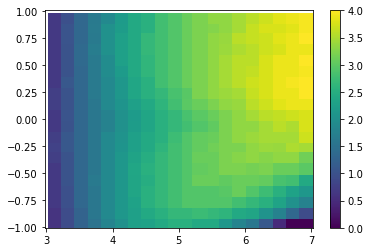

In [69]:
plt.pcolormesh(logE_mids_plot, coszen_mids_plot, data.T)
plt.colorbar()

In [72]:
# we need to get rid of the discretization from the plot first
rgi = RegularGridInterpolator((logE_mids_plot, coszen_mids_plot), data)
cc, ee = np.meshgrid(coszen_intermediate_mids, logE_intermediate_mids)
aeff_intermediate = rgi((ee, cc))

# ... and then use the finer binning
rgi2 = RegularGridInterpolator(
    (logE_intermediate_mids, coszen_intermediate_mids),
    aeff_intermediate,
    bounds_error=False,
    fill_value=None
)
cc, ee = np.meshgrid(coszen_mids, logE_mids)
aeff = rgi2((ee, cc))


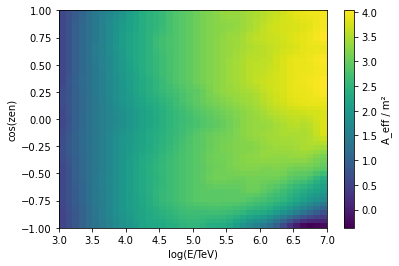

In [73]:
plt.pcolormesh(logE_bins, coszen_bins, aeff.T)
plt.colorbar(label="A_eff / m²")
plt.ylabel("cos(zen)")
plt.xlabel("log(E/TeV)")
plt.savefig("../../plots/trident_aeff.pdf")


## rotation

In [74]:
coszen_width = np.diff(coszen_bins)
ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

aeffs = {}
aeffs["local"] = 1E4 * 10 ** aeff # m² -> cm²

lon = 114.0 * u.deg
lat = 17.4 * u.deg
grid2d, eq_coords = setup_aeff_grid(
    aeffs["local"], coszen_mids, ra_mids, ra_width, local=True
)
aeffs["equatorial"] = aeff_rotation(lat, lon, eq_coords, grid2d, ra_width)


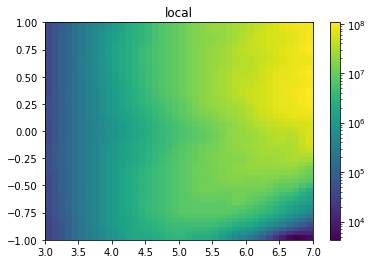

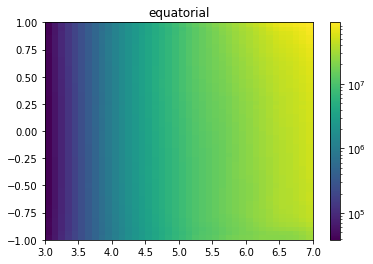

In [75]:
for key in aeffs:
    plt.figure()
    plt.pcolormesh(logE_bins, coszen_bins, aeffs[key].T, norm=LogNorm())
    plt.colorbar()
    plt.title(key)


In [76]:
to_pickle(
    (coszen_bins, logE_bins, aeffs),
    "../../resources/trident_numu_aeff_with-eq.pckl",
)


# Angular resolution

In [77]:
energy, psi = np.loadtxt(
    "../../resources/trident_psi.txt", comments="#", delimiter=","
).T


Text(0, 0.5, 'psi')

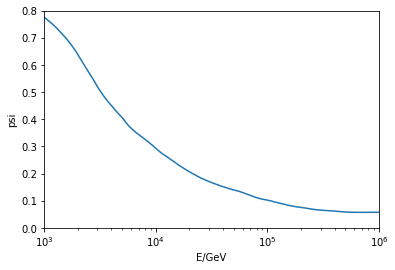

In [78]:
plt.plot(energy, psi)
plt.xscale("log")
plt.xlim(1E3, 1E6)
plt.ylim(0, 0.8)
plt.xlabel("E/GeV")
plt.ylabel("psi")

(0.001, 10)

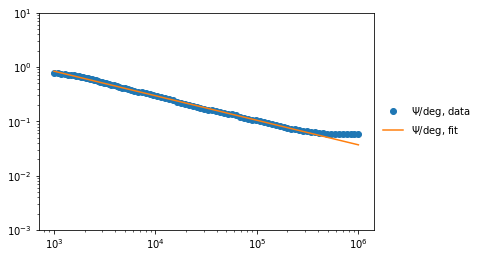

In [79]:
# psi
mask = psi >= 0.06 # floor
fit_wps = np.poly1d(np.polyfit(np.log10(energy[mask]), np.log10(psi[mask]), 1))
p2 = plt.plot(
    energy, psi, marker="o", lw=0, label=r"$\Psi / {\rm deg}$, data"
)
plt.plot(energy, 10 **fit_wps(np.log10(energy)), label=r"$\Psi / {\rm deg}$, fit")

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), framealpha=0)
plt.ylim(1e-3, 10)

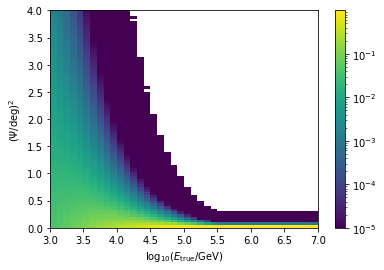

In [89]:
psi2_bins = np.arange(0, 4.01, step=0.05)
psi2_mids = get_mids(psi2_bins)
psi2_all = []
psi_floor = 0.06
for et in logE_mids:
    # integrate over bin
    if 10 ** fit_wps(et) >= psi_floor:
        tmp = 2 * (10 ** fit_wps(et)) ** 2
    else:
        tmp = 2 * psi_floor**2
    tmp = gamma.cdf(psi2_bins[1:], 1, scale=tmp) - gamma.cdf(
        psi2_bins[:-1], 1, scale=tmp
    )
    psi2_all.append(tmp / np.sum(tmp))
psi2_all = np.array(psi2_all).T

plt.figure()
plt.pcolormesh(logE_bins, psi2_bins, psi2_all, norm=LogNorm(vmin=1e-5))
plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
plt.ylabel(r"$(\Psi / {\rm deg})^2$")
plt.colorbar()

In [90]:
to_pickle(
    (psi2_all, logE_bins, psi2_bins),
    f"../../resources/trident_muon_psi_2D.pckl",
)


# Energy resolution
No info in the paper though :(

## binning

In [82]:
bin_size = 0.1 # 10 per decade
logE_min = 2.9
logE_max = 8.
logE_reco_bins = np.arange(logE_min, logE_max+bin_size, step=bin_size)
logE_reco_mids = get_mids(logE_reco_bins)

logE_reso_bins = np.arange(logE_min, logE_max, step=bin_size)
logE_reso_mids = get_mids(logE_reso_bins)

## calculation

In [83]:
def double_erf(x, shift_l, shift_r, sigma):
    # normalized such that ig goes from 0 to 1 and back to 0
    return (erf((x - shift_l) / sigma) + 1) * (-erf((x - shift_r) / sigma) + 1) / 4

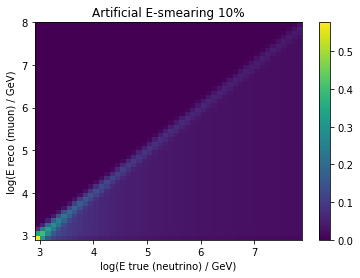

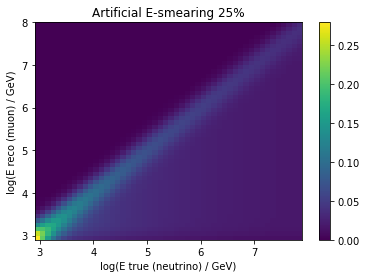

In [84]:
for res in [0.1, 0.25]:
    dx = logE_reco_bins[1] - logE_reco_bins[0]
    HE_2D = []
    sigma_S = sigma_N = res  # energy resolution in log10(E)

    for e_t in logE_reso_mids:
        mu_N = e_t
        # energy resolution of the muon in log(E)
        # and slope shape
        shift_r = mu_N - sigma_S
        shift_l = logE_min  # mu_N + np.log10(1 - 0.2) # modeling mean inelasticity y ~ 20% at E=10⁹ GeV

        norbert = norm.pdf(logE_reco_mids, loc=mu_N, scale=sigma_N)
        # normalize such that the plateau is half as high as the gauss
        siggi_norm = norm.pdf(mu_N, loc=mu_N, scale=sigma_N) / 2
        siggi = double_erf(logE_reco_mids, shift_l, shift_r, sigma_S)
        siggi *= siggi_norm

        combined = siggi + norbert
        combined /= np.sum(combined * dx)  # normalize
        HE_2D.append(combined)
    HE_2D = np.array(HE_2D).T
    HE_2D /= np.sum(HE_2D, axis=0)

    plt.figure()
    plt.pcolormesh(logE_reso_bins, logE_reco_bins, HE_2D)
    plt.ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
    plt.xlim(np.min(logE_reso_bins), np.max(logE_reso_bins))
    plt.colorbar()
    plt.title(f"Artificial E-smearing {int(res*100)}%")
    plt.ylabel("log(E reco (muon) / GeV)")
    plt.xlabel("log(E true (neutrino) / GeV)")

    ## save
    if True:
        rgi = RegularGridInterpolator((logE_reco_mids, logE_reso_mids), HE_2D)
        to_pickle(
            rgi,
            f"../../resources/trident_muon_energy_smearing_rgi_{int(res*100)}-res.pckl",
        )

        to_pickle(
            (HE_2D, logE_reso_bins, logE_reco_bins),
            f"../../resources/trident_muon_energy_smearing_2D_{int(res*100)}-res.pckl",
        )
